In [78]:
import numpy as np
from sklearn.datasets import make_spd_matrix
import math
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LassoCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [2]:
seed = 123
np.random.seed(seed)

N = 500 # No. obs 

k=100 # = No. variables in x_i 

theta=0.5 #real causal value

# Generate some fake weights for X used in generation of g and m functions
b= [1/k for k in range(1,((k+1)))]

#generate covariance matrix to be used in data generation
sigma = make_spd_matrix(k,random_state=seed) # 

MC_no = 250 # Number of simulations 

#generate predefined G as sine squared func
def g(x):
    return np.power(np.sin(x),2)

#generate predefined m as wrapped cauchy distribution with
# (nu)v=0 and gamma = 1#
def m(x,nu=0.,gamma=1.):
    return 0.5/math.pi*(np.sinh(gamma))/(np.cosh(gamma)-np.cos(x-nu))

In [ ]:
# Create empty array to store estimated thetas     
theta_est = np.zeros(shape=[MC_no,4])

In [3]:

#for each simulation
for i in range(MC_no):
    
    # Generate data: 
    #no. obs x no. variables in x_i     
    X = np.random.multivariate_normal(np.ones(k),sigma,size=[N,])
    
    #generate function g of data X * bias
    G_of_X = g(np.dot(X,b)) 

    #generate function m of data X * bias
    M_of_X = m(np.dot(X,b)) 
    
    error_d = np.random.standard_normal(size=[N,]) 
    #generate D treatment
    D = M_of_X+error_d
    
    error_y = np.random.standard_normal(size=[N,])
    
    #generate Y
    Y = np.dot(theta,D)+ G_of_X + error_y 
    
    #
    # Now run the different methods     # 
    ######################################################################    
    # OLS --------------------------------------------------     
    ######################################################################
    OLS = sm.OLS(Y,D)
    results = OLS.fit()
    #save OLS estimate into theta_estimate array
    theta_est[i][0] = results.params[0]
    
 
    ######################################################################
    # DML package                      -----------------------------------     
    ######################################################################
    # DML DML1 algo                    -----------------------------------     
    ######################################################################
    dml_data = DoubleMLData.from_arrays(X, Y, D)

    ml_g_rf = RandomForestRegressor(max_depth=2)
    ml_m_rf = RandomForestRegressor(max_depth=2)
    
    dml_plr_tree = DoubleMLPLR(dml_data,
                             ml_g = ml_g_rf,
                             ml_m = ml_m_rf,
                             n_folds = 2,
                             n_rep = 1,
                             score = 'partialling out',
                             dml_procedure = 'dml1')
    #estimation
    dml_plr_tree.fit()
    
    #coefficient estimate
    theta_est[i][1] = dml_plr_tree.coef
    
    
    ######################################################################
    # Naive double machine Learning 
    # With orthogonal (for regularisation)
    # No Cross fitting (for bias)
    ######################################################################
    
    naiveDMLg =RandomForestRegressor(max_depth=4)

    # Compute ghat     
    naiveDMLg.fit(X,Y)
    Ghat = naiveDMLg.predict(X)
    
    # Compute ghat     
    naiveDMLm =RandomForestRegressor(max_depth=4)
    naiveDMLm.fit(X,D)
    Mhat = naiveDMLm.predict(X)
    
    # vhat as residual, orthogonalized regressors     
    Vhat = D-Mhat
    
    #save Naive ML estimate into theta_estimate array
    theta_est[i][2] = np.mean(np.dot(Vhat,Y-Ghat))/np.mean(np.dot(Vhat,D))


    ######################################################################
    # Cross-fitting DML -----------------------------------     
    ######################################################################
    # Split the sample   
    kf = KFold(n_splits = 2)
    kf.get_n_splits(X)
    
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        D_train, D_test = D[train_index], D[test_index]
    
    # Ghat for both     
    Ghat_1 = RandomForestRegressor(max_depth=2).fit(X_train,y_train).predict(X_test)
    Ghat_2 = RandomForestRegressor(max_depth=2).fit(X_test,y_test).predict(X_train)
    # Mhat and vhat for both     
    Mhat_1 = RandomForestRegressor(max_depth=2).fit(X_train,D_train).predict(X_test)
    Mhat_2 = RandomForestRegressor(max_depth=2).fit(X_test,D_test).predict(X_train)    
    
    #orthogonalized regressors
    Vhat_1 = D_test -  Mhat_1
    Vhat_2 = D_train - Mhat_2
    
    theta_1 = np.mean(np.dot(Vhat_1,(y_test-Ghat_1)))/np.mean(np.dot(Vhat_1,D_test))
    theta_2 = np.mean(np.dot(Vhat_2,(y_train-Ghat_2)))/np.mean(np.dot(Vhat_2,D_train))
    
    #get avg of each theta estimate and store
    theta_est[i][3] = np.mean([[theta_1, theta_2]])

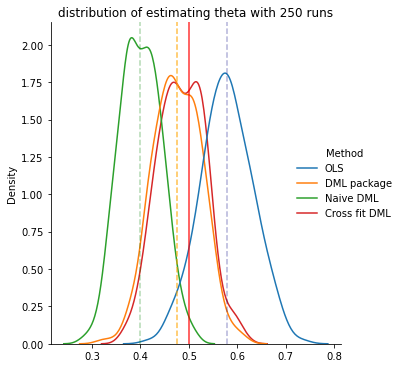

In [4]:
#generate density plot
g = sns.displot(theta_est, kind="kde", legend=True).set(title='distribution of estimating theta with {} runs'.format(MC_no))
# title
new_title = 'Method'
g._legend.set_title(new_title)
# replace labels
new_labels = ['OLS','DML package' ,'Naive DML','Cross fit DML']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
ols_mean = theta_est[:,0].mean()
plt.axvline(ols_mean, c = 'navy', ls = '--', alpha = 0.3)
naive_mean = theta_est[:,1].mean()
plt.axvline(naive_mean, c='orange',ls = '--', alpha = 0.7)
crossfit_dml_mean = theta_est[:,2].mean()
plt.axvline(crossfit_dml_mean, c = 'green',ls = '--', alpha = 0.3)
plt.axvline(theta, c = 'red',ls = '-', alpha = 0.8)

In [ ]:
hjyuy

In [128]:
from doubleml.datasets import fetch_401K

In [129]:
#fetch data

data = fetch_401K(return_type='DataFrame')
data

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
0,0.0,0.0,4500.0,47,6765.0,2,8,0,0,0,0,0,0,1
1,6215.0,1015.0,22390.0,36,28452.0,1,16,0,0,0,0,0,0,1
2,0.0,-2000.0,-2000.0,37,3300.0,6,12,1,0,0,0,0,0,0
3,15000.0,15000.0,155000.0,58,52590.0,2,16,0,1,1,0,0,0,1
4,0.0,0.0,58000.0,32,21804.0,1,11,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9910,98498.0,98858.0,157858.0,52,73920.0,1,16,1,0,0,1,1,0,1
9911,287.0,6230.0,15730.0,41,42927.0,4,14,0,1,1,1,1,1,1
9912,99.0,6099.0,7406.0,40,23619.0,2,16,1,0,0,1,0,1,0
9913,0.0,-32.0,2468.0,47,14280.0,4,6,1,0,0,1,1,0,0


In [130]:
#unconditional Average Predictive Effect of 401k eligibility on accumulated assets
data[['e401', 'net_tfa']].groupby('e401').mean().diff()

,net_tfa
e401,
0,NaN
1,19559.34375


In [131]:
#how many are eligible and how many participated
data[['p401', 'net_tfa']].groupby('p401').mean().diff()

,net_tfa
p401,
0,NaN
1,27371.582031


In [132]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Set up a model according to regression formula with polynomials
features = data.copy()[['marr', 'twoearn', 'db', 'pira', 'hown']]

poly_dict = {'age': 2,
             'inc': 2,
             'educ': 2,
             'fsize': 2}
for key, degree in poly_dict.items():
    poly = PolynomialFeatures(degree, include_bias=False)
    data_transf = poly.fit_transform(data[[key]])
    x_cols = poly.get_feature_names_out([key])
    data_transf = pd.DataFrame(data_transf, columns=x_cols)

    features = pd.concat((features, data_transf),
                          axis=1, sort=False)

model_data = pd.concat((data.copy()[['net_tfa', 'e401']], features.copy()),
                        axis=1, sort=False)

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_flex = DoubleMLData(model_data, y_col='net_tfa', d_cols='e401')

In [133]:
X = model_data[['age', 'inc', 'educ', 'fsize', 'marr',
                 'twoearn', 'db', 'pira', 'hown']].to_numpy()

D = model_data[['e401']].to_numpy()

Y = model_data[['net_tfa']].to_numpy()

In [134]:
Y.shape, X.shape

((9915, 1), (9915, 9))

In [179]:
MC_no= 100

# Create empty array to store estimated thetas     
theta_est = np.zeros(shape=[MC_no,6])

shallow_rf = pd.DataFrame(columns=['coef', 'std err', 'P>|t|','2.5%','97.5%'])
deep_rf = pd.DataFrame(columns=['coef', 'std err', 'P>|t|','2.5%','97.5%'])
naive_dml = pd.DataFrame(columns=['coef', 'std err', 'P>|t|','2.5%','97.5%'])
deep_rf_tworeg = pd.DataFrame(columns=['coef', 'std err', 'P>|t|','2.5%','97.5%'])
naive_ = pd.DataFrame(columns=['coef', 'std err', 'P>|t|','2.5%','97.5%'])

In [180]:
#for each simulation
for i in range(MC_no):
    #
    # Now run the different methods     # 
    ######################################################################    
    # OLS --------------------------------------------------     
    ######################################################################
    OLS = sm.OLS(Y,D.ravel())
    results = OLS.fit()
    #save OLS estimate into theta_estimate array
    theta_est[i][0] = results.params[0]
    
    ######################################################################
    # shallow DML DML1 algo                    -----------------------------------     
    ######################################################################
    dml_data = DoubleMLData.from_arrays(X, Y.ravel(), D)

    ml_g_rf = RandomForestRegressor(max_depth=4)
    ml_m_rf = RandomForestRegressor(max_depth=4)
    
    shallow_dml_plr_tree = DoubleMLPLR(dml_data,
                             ml_g = ml_g_rf,
                             ml_m = ml_m_rf,
                             n_folds = 2,
                             n_rep = 1,
                             score = 'partialling out',
                             dml_procedure = 'dml1')
    #estimation
    shallow_dml_plr_tree.fit(store_predictions=True)
    
    #coefficient estimate
    theta_est[i][1] = shallow_dml_plr_tree.coef
    
    shallow_rf = shallow_rf.append(shallow_dml_plr_tree.summary)
    
    ######################################################################
    # DML deeper DML1 algo two regressors     
    ######################################################################    
    
    
    dml_data = DoubleMLData.from_arrays(X, Y.ravel(), D)

    ml_g_rf = RandomForestRegressor(n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
    ml_m_rf = RandomForestRegressor(n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)
    deep_dml_plr_tree = DoubleMLPLR(dml_data,
                             ml_g = ml_g_rf,
                             ml_m = ml_m_rf,
                             n_folds = 1)
    #estimation
    deep_dml_plr_tree.fit(store_predictions=True)
    
    #coefficient estimate
    theta_est[i][2] = deep_dml_plr_tree.coef
    deep_rf_tworeg = deep_rf_tworeg.append(deep_dml_plr_tree.summary)
    
    ######################################################################
    # DML deeper DML1 algo    classifier-----------------------------------     
    ######################################################################
    dml_data = DoubleMLData.from_arrays(X, Y.ravel(), D)

    ml_g_rf = RandomForestRegressor(n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
    ml_m_rf = RandomForestClassifier(n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)
    deep_dml_plr_tree = DoubleMLPLR(dml_data,
                             ml_g = ml_g_rf,
                             ml_m = ml_m_rf,
                             n_folds = 3)
    #estimation
    deep_dml_plr_tree.fit(store_predictions=True)
    
    #coefficient estimate
    theta_est[i][3] = deep_dml_plr_tree.coef
    deep_rf = deep_rf.append(deep_dml_plr_tree.summary)
    
    ######################################################################
    # Naive double machine Learning 
    # With orthogonal (for regularisation)
    # No Cross fitting (for bias)
    ######################################################################
    
    #naiveDMLg =RandomForestRegressor(max_depth=4)

    # Compute ghat     
    #naiveDMLg.fit(X,Y.ravel())
    #Ghat = naiveDMLg.predict(X)
    
    # Compute ghat     
    #naiveDMLm =RandomForestRegressor(max_depth=4)
    #naiveDMLm.fit(X,D.ravel())
    #Mhat = naiveDMLm.predict(X)
    
    # vhat as residual, orthogonalized regressors     
    #Vhat = D-Mhat
    
    #save Naive ML estimate into theta_estimate array
    #theta_est[i][4] = np.mean(np.dot(Vhat,Y-Ghat))/np.mean(np.dot(Vhat,D))
    
    ######################################################################
    # Naive double machine Learning 
    # With orthogonal (for regularisation)
    # No Cross fitting (for bias)
    ######################################################################    
    
    
    dml_data = DoubleMLData.from_arrays(X, Y.ravel(), D)

    ml_g_rf = RandomForestRegressor(n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
    ml_m_rf = RandomForestClassifier(n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)
    deep_dml_plr_tree = DoubleMLPLR(dml_data,
                             ml_g = ml_g_rf,
                             ml_m = ml_m_rf,
                             n_folds = 1)
    #estimation
    deep_dml_plr_tree.fit(store_predictions=True)
    
    #coefficient estimate
    theta_est[i][5] = deep_dml_plr_tree.coef
    naive_ = naive_.append(deep_dml_plr_tree.summary)

/Users/danielscott/opt/anaconda3/lib/python3.8/site-packages/doubleml/double_ml.py:90: UserWarning: apply_cross_fitting is set to False. Cross-fitting is not supported for n_folds = 1.
  warnings.warn('apply_cross_fitting is set to False. Cross-fitting is not supported for n_folds = 1.')
/Users/danielscott/opt/anaconda3/lib/python3.8/site-packages/doubleml/double_ml.py:90: UserWarning: apply_cross_fitting is set to False. Cross-fitting is not supported for n_folds = 1.
  warnings.warn('apply_cross_fitting is set to False. Cross-fitting is not supported for n_folds = 1.')
/Users/danielscott/opt/anaconda3/lib/python3.8/site-packages/doubleml/double_ml.py:90: UserWarning: apply_cross_fitting is set to False. Cross-fitting is not supported for n_folds = 1.
  warnings.warn('apply_cross_fitting is set to False. Cross-fitting is not supported for n_folds = 1.')
/Users/danielscott/opt/anaconda3/lib/python3.8/site-packages/doubleml/double_ml.py:90: UserWarning: apply_cross_fitting is set to Fal

KeyboardInterrupt: 

In [187]:
deep_dml_plr_tree.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
d,8966.886831,1303.267086,6.880314,5.972076e-12,6412.53028,11521.243383


In [139]:
print("OLS avg {:.1f}, shallow DML RF {:.1f}, deeper DML RF {:.1f}, naive DML RF no xfitting {:.1f}".format(theta_est[:,0].mean(),theta_est[:,1].mean(),theta_est[:,2].mean(),theta_est[:,3].mean()))

OLS avg 30347.4, shallow DML RF 8593.4, deeper DML RF 8985.8, naive DML RF no xfitting 75874.3


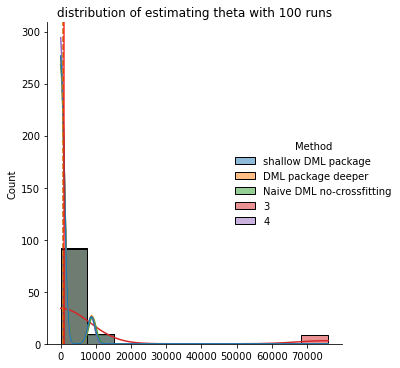

In [182]:
#generate density plot
g = sns.displot(theta_est[:,1:6],kde=True, legend=True).set(title='distribution of estimating theta with {} runs'.format(MC_no))
# title
new_title = 'Method'
g._legend.set_title(new_title)
# replace labels
new_labels = ['shallow DML package' ,'DML package deeper','Naive DML no-crossfitting']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#ols_mean = theta_est[:,0].mean()
#plt.axvline(ols_mean, c = 'green', ls = '--', alpha = 0.3)
shallow_dml = theta_est[:,1].mean()
plt.axvline(shallow_dml, c='navy',ls = '--', alpha = 0.7)
deep_dml = theta_est[:,2].mean()
plt.axvline(deep_dml, c = 'orange',ls = '--', alpha = 0.9)
naive_dml = theta_est[:,3].mean()
plt.axvline(naive_dml, c = 'red',ls = '-', alpha = 0.8)
#plt.xlim(6000,11000)
plt.show()

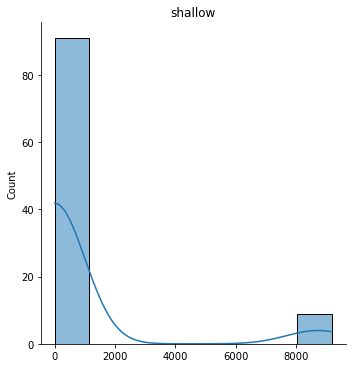

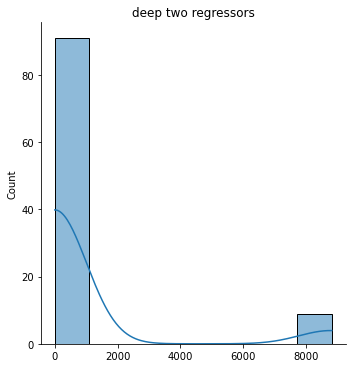

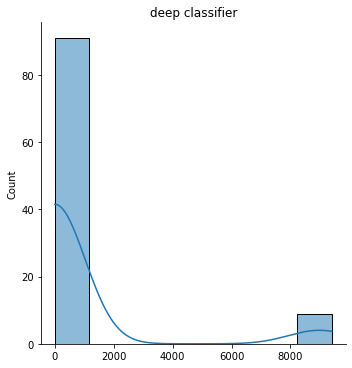

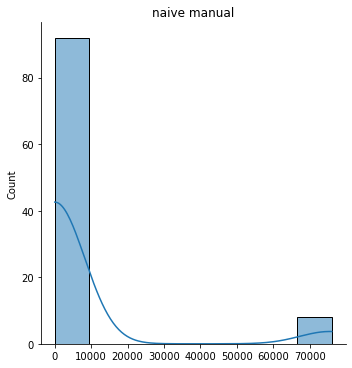

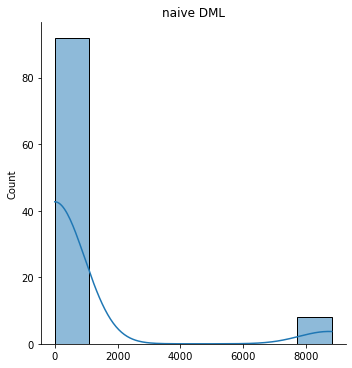

In [183]:
#generate density plot
sns.displot(theta_est[:,1],kde=True, legend=True).set(title='shallow')
sns.displot(theta_est[:,2],kde=True, legend=True).set(title='deep two regressors')
sns.displot(theta_est[:,3],kde=True, legend=True).set(title='deep classifier')
sns.displot(theta_est[:,4],kde=True, legend=True).set(title='naive manual')
sns.displot(theta_est[:,5],kde=True, legend=True).set(title='naive DML')

In [151]:
plr_summary = pd.concat((shallow_rf.mean().to_frame().T, deep_rf.mean().to_frame().T))
plr_summary.index = ['shallow', 'deep']
plr_summary[['coef', '2.5 %', '97.5 %']]

,coef,2.5 %,97.5 %
shallow,8593.360843,5955.081377,11231.640308
deep,8985.751411,6400.052830,11571.449993


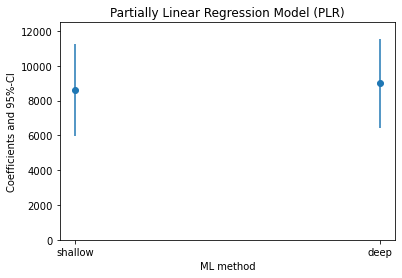

In [152]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.ylim([0, 12500])

plt.title('Partially Linear Regression Model (PLR)')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')